This notebook focuses on analysing the Seattle AirBnB dataset available from [Kaggle](https://www.kaggle.com/airbnb/seattle/data). This notebook was done as a project for the Data Scientist Nanodegree program on Udacity.

# Package import ad paths setup

!pip install missingno

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import missingno
import seaborn as sns
from functools import reduce

In [2]:
%matplotlib inline

In [3]:
DATA_FOLDER = Path('../data')

In [4]:
!ls $DATA_FOLDER

calendar.csv  reviews.csv  X_train.pkl	y_train.pkl
listings.csv  X_test.pkl   y_test.pkl


In [5]:
calendar = pd.read_csv(DATA_FOLDER / 'calendar.csv')
listings = pd.read_csv(DATA_FOLDER / 'listings.csv')
reviews = pd.read_csv(DATA_FOLDER / 'reviews.csv')

# Data quality

In this first section we will look into the quality of the data. Specifically we will look at missing values in the data. I like to use the package [missingno](https://github.com/ResidentMario/missingno), which gives a good overview of columns and where there are missing values.

## Calendar data

In [6]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


From the info above, we have some columns that need cleaning and type conversion. The date column needs to be converted to a datetime type and the price column needs to be cleaned and converted into a float type.

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


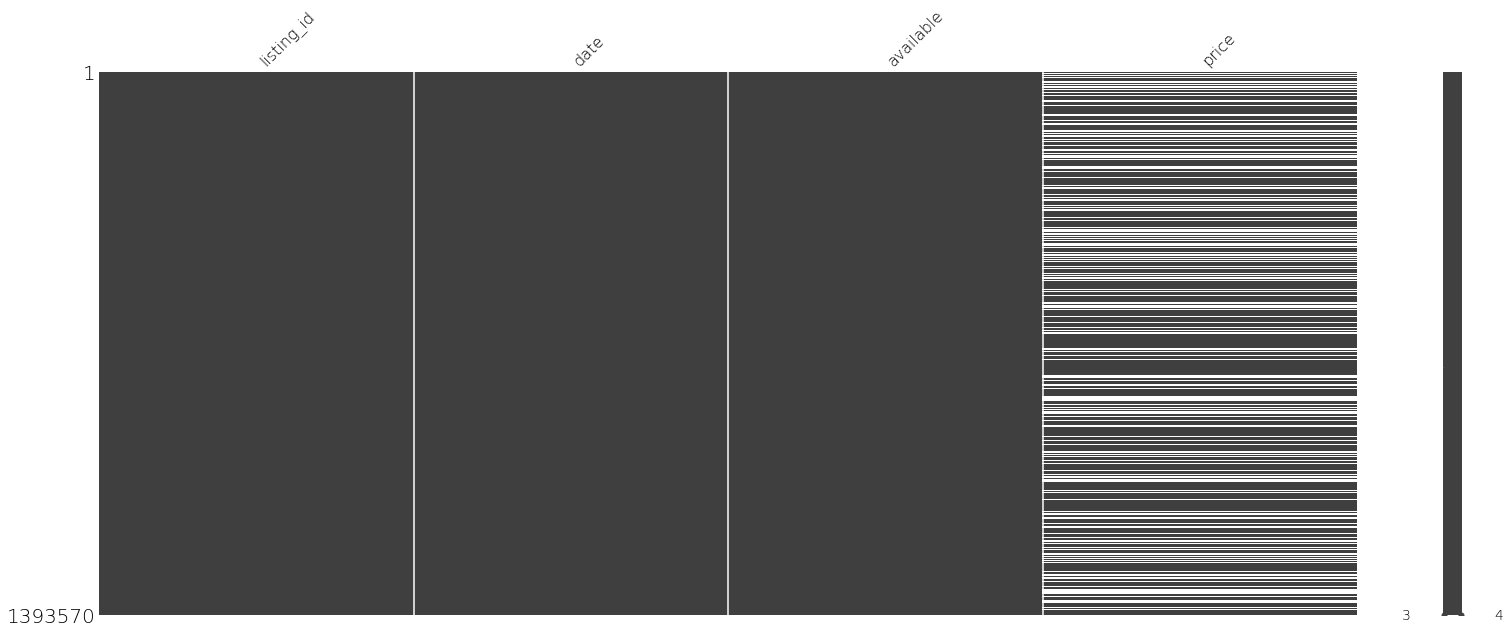

In [8]:
missingno.matrix(calendar);

This data shows what prices listings have had at a given time. Also it shows if the listing has been rented out or not.

Apparent from above is that the price column often has null values. Seing as the data lists prices and availability given a certain date, it is possible that this is a natural thing, since listings will be shown without prices, whenever they are rented out to visitors. We can investigate this by filtering all rows where `available == 'f'` and counting number of unique values

In [9]:
calendar[calendar['available'] == 'f']['price'].value_counts()

Series([], Name: price, dtype: int64)

Indeed for all rows where the listing is not available, price will be a NaN. We can also investigate if there are any rows with available listings where the price is NaN

In [10]:
calendar_nans = calendar[calendar.isna().any(axis=1)]

In [11]:
len(calendar_nans[calendar_nans['available'] == 't'])

0

This shows that the data is clean and we have a price for every row where a listing is available.

In [12]:
print(f'Number of rows in calendar data: {len(calendar)}')

Number of rows in calendar data: 1393570


### Cleaning

In [13]:
def clean_calendar(calendar):
    calendar_clean = calendar.copy()
    
    # Converting the date to a pandas datetime type
    calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])
    
    # Removing calendar entries from when the properties are rented out
    #calendar_clean = calendar_clean[calendar_clean['available'] == 't']
    
    # Converting price to a float value
    calendar_clean['cleaned_price'] = calendar_clean['price'].str.replace('[$,]','').astype('float')
    
    return calendar_clean

In [14]:
calendar_clean = clean_calendar(calendar)

## Listings data

In [15]:
# Allow printing of more rows, so we can see content of all columns in listings dataframe.
pd.options.display.max_rows = len(listings.columns)

In [16]:
listings.sample(10).T

,2941,3280,2746,3556,1525,957,1721,1416,1217,3790
id,7087957,9460991,7902137,194313,6691324,8372562,10122924,4082986,3534364,2755730
listing_url,https://www.airbnb.com/rooms/7087957,https://www.airbnb.com/rooms/9460991,https://www.airbnb.com/rooms/7902137,https://www.airbnb.com/rooms/194313,https://www.airbnb.com/rooms/6691324,https://www.airbnb.com/rooms/8372562,https://www.airbnb.com/rooms/10122924,https://www.airbnb.com/rooms/4082986,https://www.airbnb.com/rooms/3534364,https://www.airbnb.com/rooms/2755730
scrape_id,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432
last_scraped,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04
name,"Quaint, charming, updated studio",Cozy house with trees & quiet. Yard,"100WalkScore, Hotel Qlty, FreeBkfst",Slanted Ivy Vacation Rental,Beautiful Apartment! 99 Walkscore,Luxury Lakeside Home with Views!,West Seattle 1BR Condo - nice view,Lovely Studio Apt in D.T. Seattle !,Studio with a Bay View,Your own 2 Bedroom home in Fremont
summary,"Old world, beautifuly restored building at 14t...",Nice house with shared kitchen. Trees and big ...,Need a place to relax comfortably and still ge...,Charming studio in the basement of my 1910 Cra...,"Centrally located in Downtown Seattle, this ho...",This three-bedroom home boasts south-eastern w...,Views of Puget Sound - 1 bedroom condo updated...,"LOCATION, LOCATION - CLEAN and cozy Studio...",Want a view of the water and to be near downto...,Private 2 bedroom retreat in the heart of Frem...
space,With a Walk Score of 98 and easy access to mul...,NaN,Your bedroom has a queen-sized bed with some s...,"This charming, mother-in-law studio is the per...",NaN,"In this spacious home, you'll feel on top of t...",NaN,Welcome to beautiful Seattle. Building is loca...,View of the bay. One floor up is rooftop with ...,The house was built in 1906 by the Seattle Lum...
description,"Old world, beautifuly restored building at 14t...",Nice house with shared kitchen. Trees and big ...,Need a place to relax comfortably and still ge...,Charming studio in the basement of my 1910 Cra...,"Centrally located in Downtown Seattle, this ho...",This three-bedroom home boasts south-eastern w...,Views of Puget Sound - 1 bedroom condo updated...,"LOCATION, LOCATION - CLEAN and cozy Studio...",Want a view of the water and to be near downto...,Private 2 bedroom retreat in the heart of Frem...
experiences_offered,none,none,none,none,none,none,none,none,none,none
neighborhood_overview,The Pike/Pine area on Capitol is a bustling ne...,NaN,The location is perfect -- near all of the bes...,My neighborhood is the quiet residential part ...,NaN,Leschi is a small neighborhood right on Lake W...,NaN,The best location in town! located 2 blocks fr...,Right on the edge of Lower Queen Anne and Bell...,"Very walkable, with lots of bike lanes and qui..."


In [17]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

A few columns need to be cleaned and converted to right type.

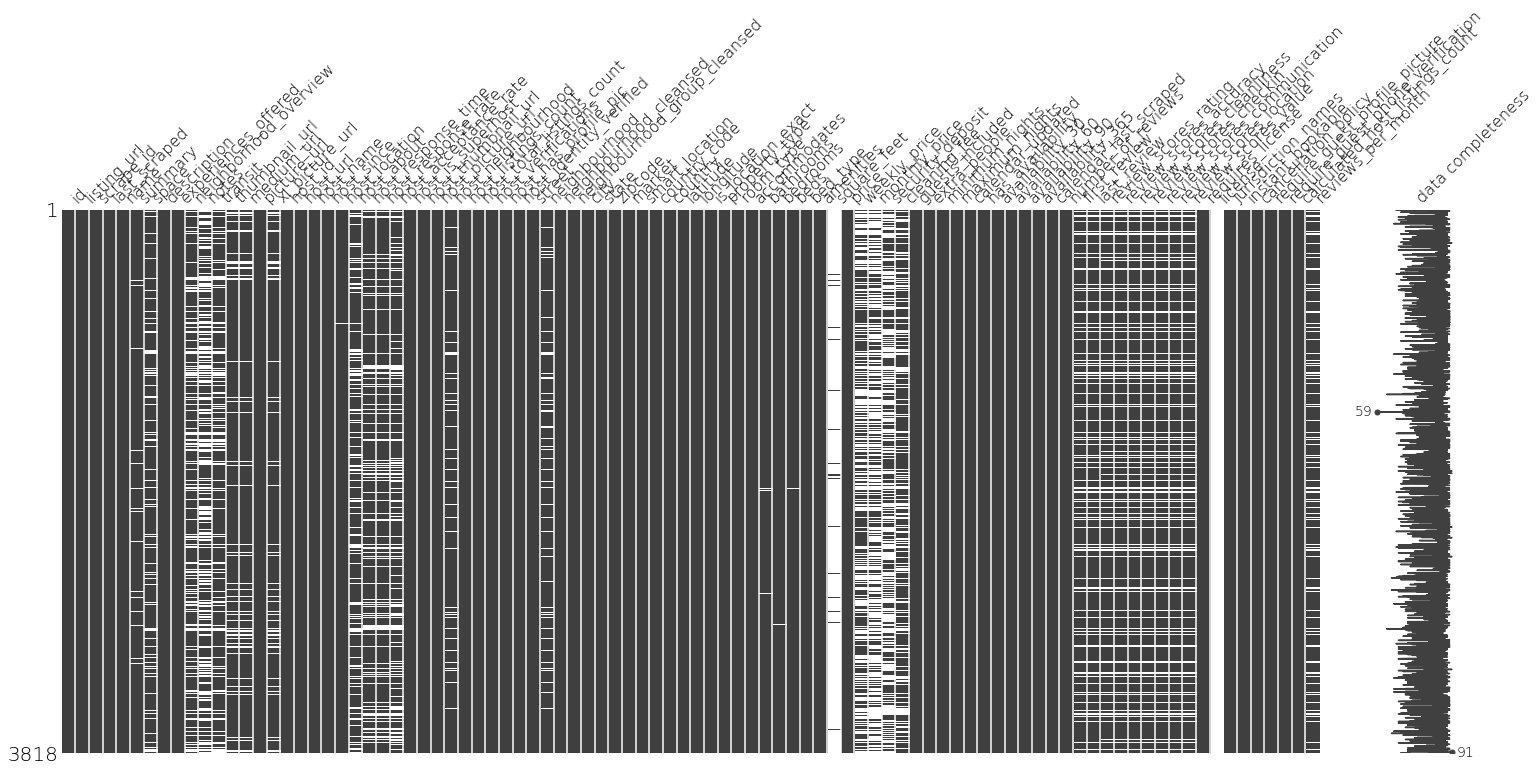

In [18]:
missingno.matrix(listings, labels=True);

This data describes each of the listings on AirBnB. There are a total of 91 columns and a lot of them have missing values at various places. 

The row with the minium missing values still has 59 values missing, and the row with the maximum values missing has 91 values missing. 

There are good reasons for listing data to have missing values since listings are of various types, also the owner might not have completed the many ways in which there is to describe the listing.

In [19]:
print(f'Number of rows in listings: {len(listings)}')

Number of rows in listings: 3818


### Cleaning

In [20]:
def clean_listings(listings):
    listings_clean = listings.copy()

    # Converting percentage strings into floats
    listings_clean['host_response_rate'] = listings_clean['host_response_rate'].str.replace('%','').astype('float')
    listings_clean['host_acceptance_rate'] = listings_clean['host_acceptance_rate'].str.replace('%','').astype('float')
    
    # Converting price to a float value
    listings_clean['price'] = listings_clean['price'].str.replace('[$,]','').astype('float')
    listings_clean['weekly_price'] = listings_clean['weekly_price'].str.replace('[$,]','').astype('float')
    listings_clean['monthly_price'] = listings_clean['monthly_price'].str.replace('[$,]','').astype('float')
    listings_clean['security_deposit'] = listings_clean['security_deposit'].str.replace('[$,]','').astype('float')
    listings_clean['cleaning_fee'] = listings_clean['cleaning_fee'].str.replace('[$,]','').astype('float')
    listings_clean['extra_people'] = listings_clean['extra_people'].str.replace('[$,]','').astype('float')
    
    # Converting the date to a pandas datetime type
    listings_clean['last_scraped'] = pd.to_datetime(listings_clean['last_scraped'])
    listings_clean['host_since'] = pd.to_datetime(listings_clean['host_since'])
    listings_clean['calendar_last_scraped'] = pd.to_datetime(listings_clean['calendar_last_scraped'])
    listings_clean['first_review'] = pd.to_datetime(listings_clean['first_review'])
    listings_clean['last_review'] = pd.to_datetime(listings_clean['last_review'])
    
    return listings_clean

In [21]:
listings_clean = clean_listings(listings)

## Reviews

In [22]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


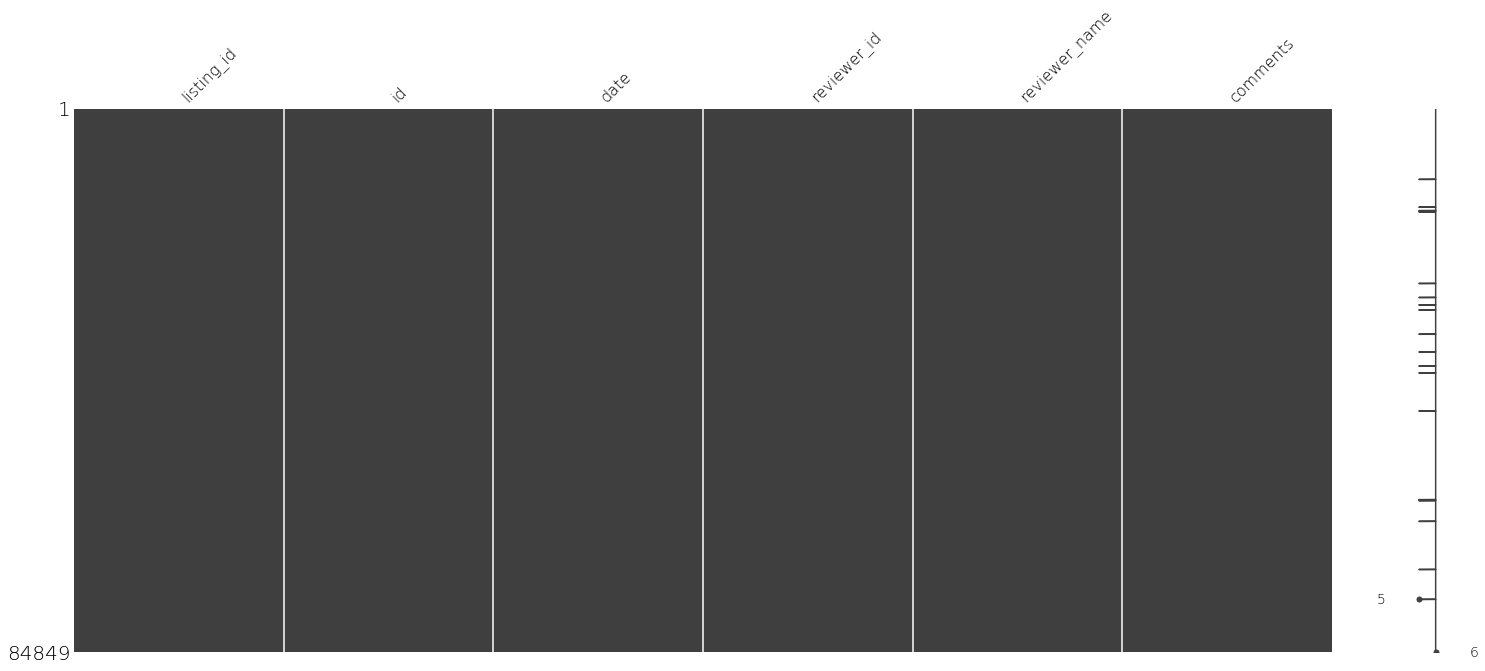

In [23]:
missingno.matrix(reviews)

This data shows the visitors reviews in text for a given listing, at a given date. Remarkably there are very few missing values.

In [24]:
print(f'Number of rows in reviews: {len(reviews)}')

Number of rows in reviews: 84849


# Business Understanding

Questions to answer with the data
- What is the yearly price trend?
- What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?
- Are there any property types that demand a higher price than others?
- How many consecutive days are properties usually rented out for?

# Q1: What is the yearly price trend

In [25]:
calendar_stats = calendar_clean[calendar_clean['available'] == 't'].groupby(['date']).agg({'cleaned_price':{'min','max','std','mean'}})
calendar_year = calendar_stats['2016-01-01':'2016-12-31']
calendar_month = calendar_stats.resample('M').mean()
calendar_month['month_names'] = calendar_month.index.strftime('%b')

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


Mean price: $137.66


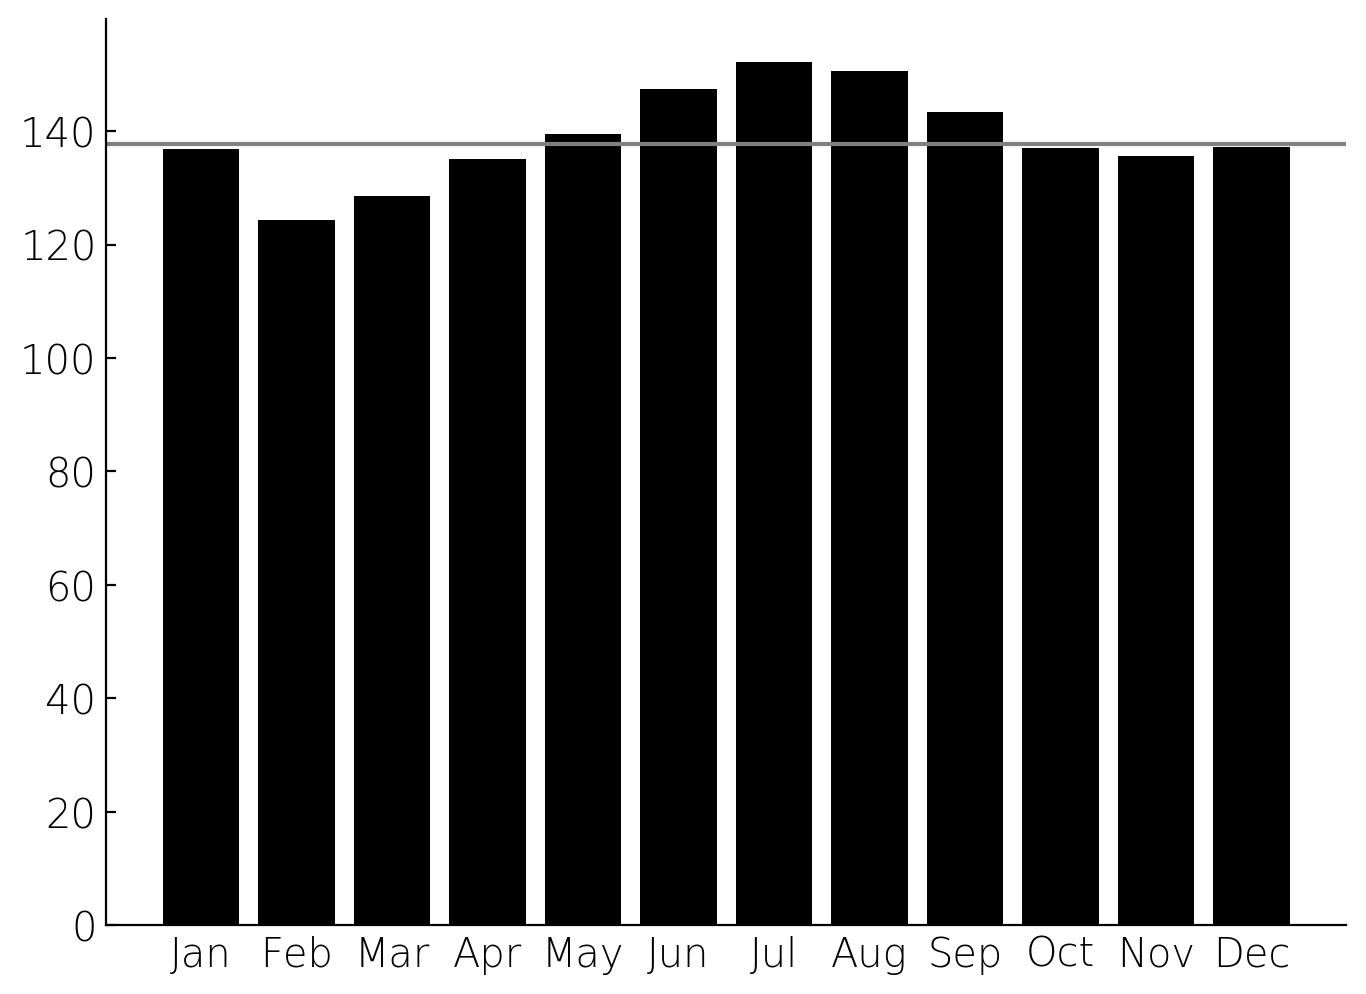

In [26]:
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
ax.bar(calendar_month['month_names'], calendar_month['cleaned_price']['mean'], color='k')
price_mean = calendar_month['cleaned_price']['mean'].mean()
ax.axhline(calendar_month['cleaned_price']['mean'].mean(), c='gray')
print(f'Mean price: ${round(price_mean,2)}')
ax.grid(False)
ax.set_ylim(0,None);

From above the average price doesn't vary much over the year.

# Q2: What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?

In [27]:
neighbourhood_price = listings_clean[['id', 'neighbourhood_cleansed']].merge(calendar_clean, left_on='id', right_on='listing_id')

In [28]:
neighbourhood_pivot = neighbourhood_price.pivot(columns='neighbourhood_cleansed', values='cleaned_price')
neighbourhood_sort_index = neighbourhood_pivot.mean().sort_values(ascending=False).index

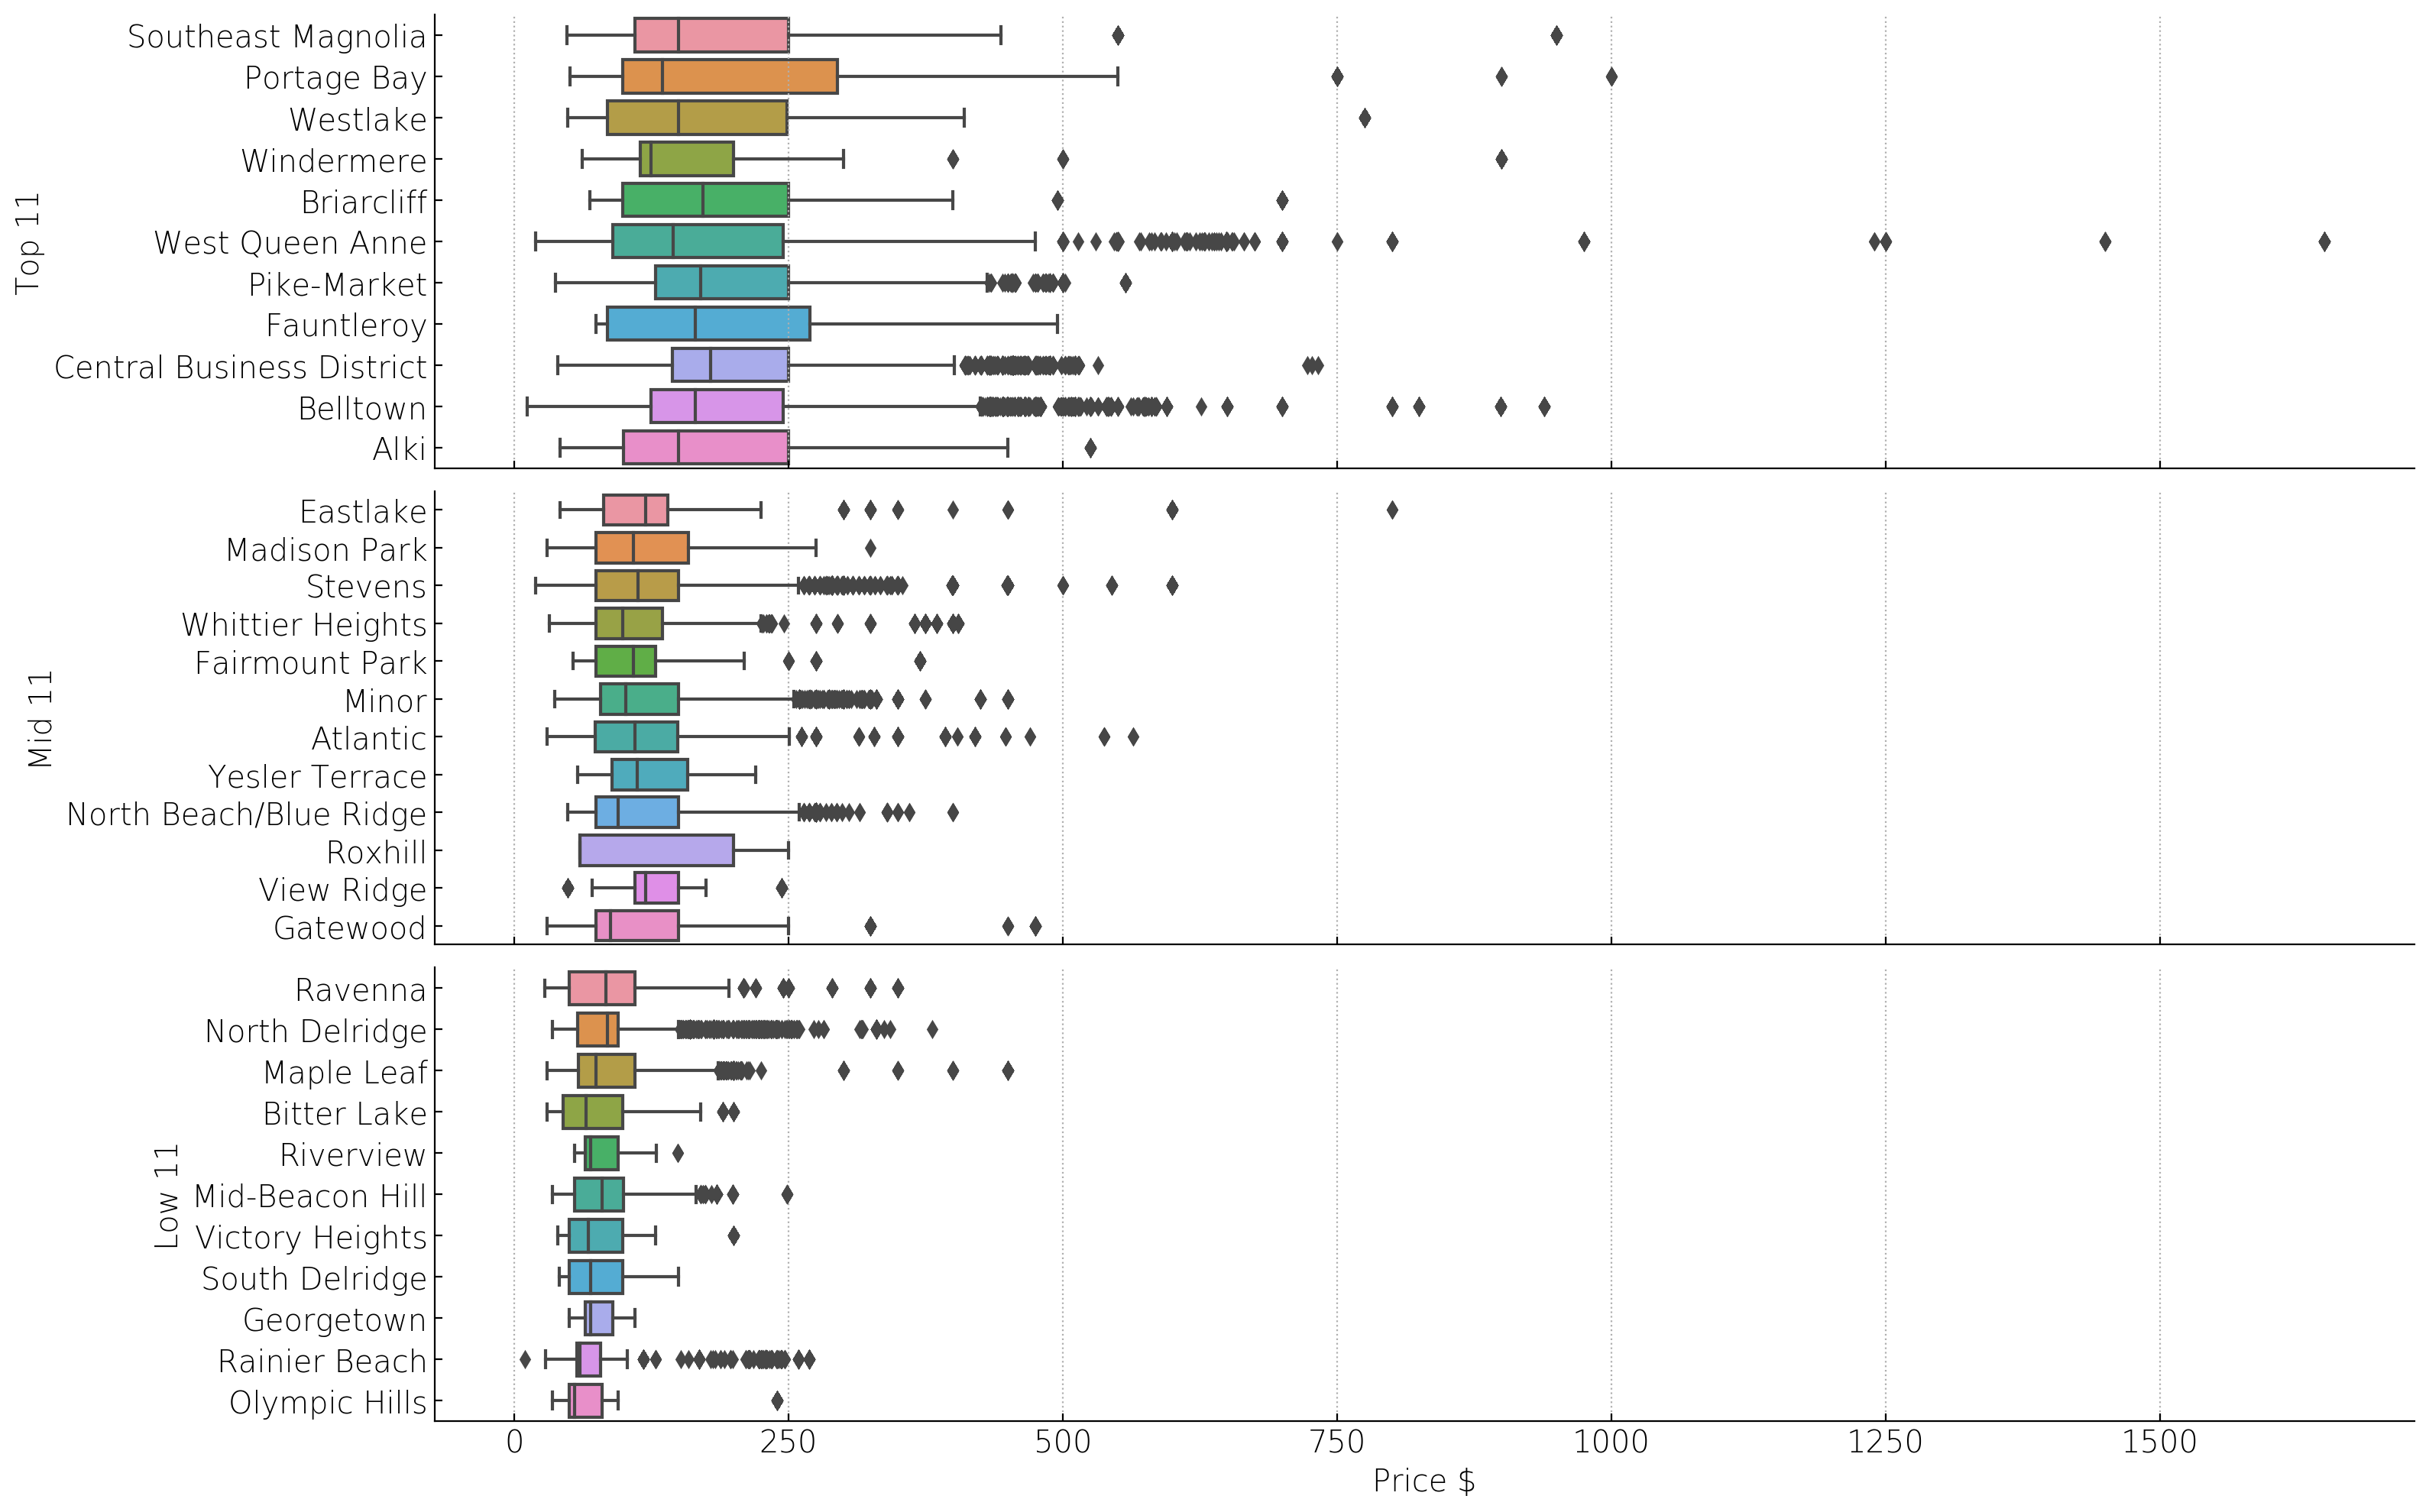

In [29]:
fig,ax = plt.subplots(3,1, figsize=(16,10), sharex=True, dpi=200)

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[:11]], orient='h', ax=ax[0])
ax[0].set_ylabel('Top 11')

midpoint = len(neighbourhood_sort_index)/2
sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[round(midpoint-5):round(midpoint+6)]], orient='h', ax=ax[1])
ax[1].set_ylabel('Mid 11')

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[-11:]], orient='h', ax=ax[2])
ax[2].set_ylabel('Low 11')
ax[2].set_xlabel('Price $')

fig.set_tight_layout(True);

# Q3: Property types vs price

In [30]:
room_type_price = listings_clean[['id', 'property_type']].merge(calendar_clean, left_on='id', right_on='listing_id')
room_type_price_pivot = room_type_price.pivot(columns='property_type', values='cleaned_price')

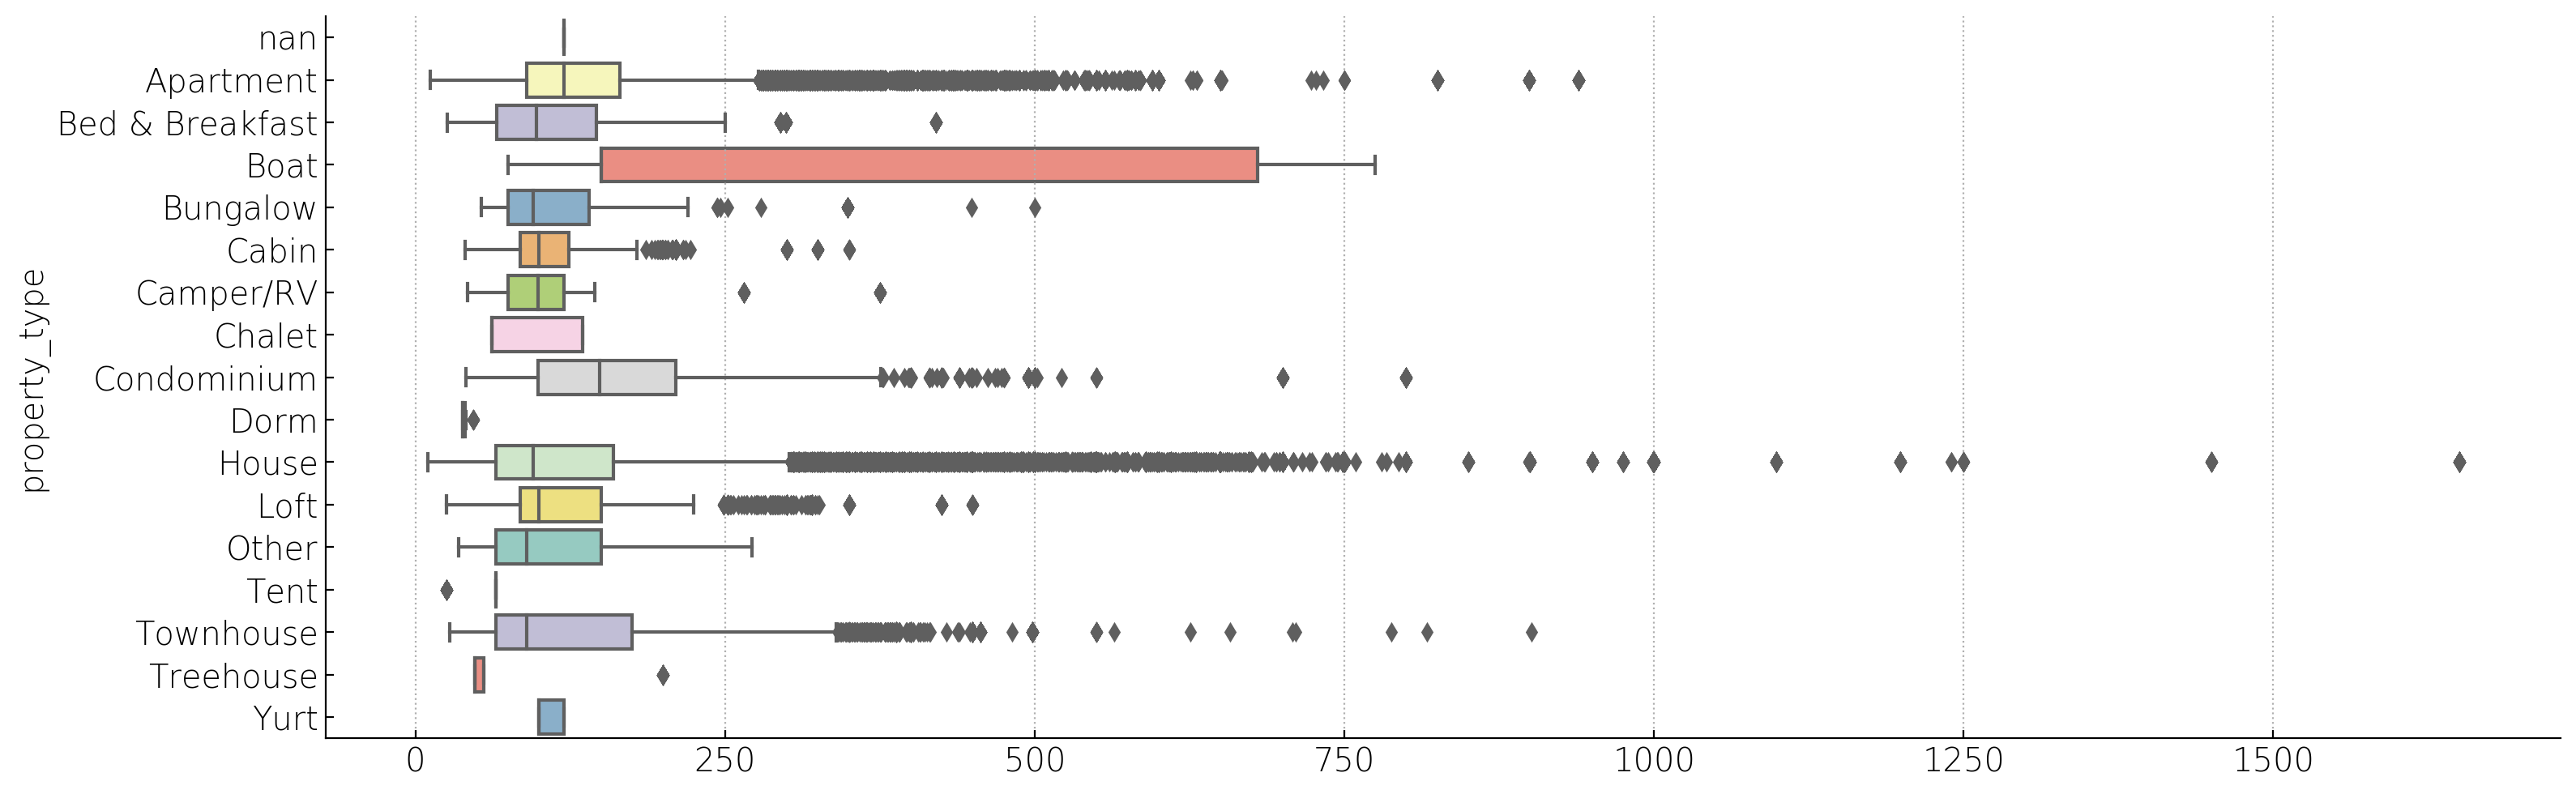

In [31]:
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.boxplot(data=room_type_price_pivot, orient='h', ax=ax, palette='Set3')
fig.set_tight_layout(True);

## Q4: Yearly availability trend

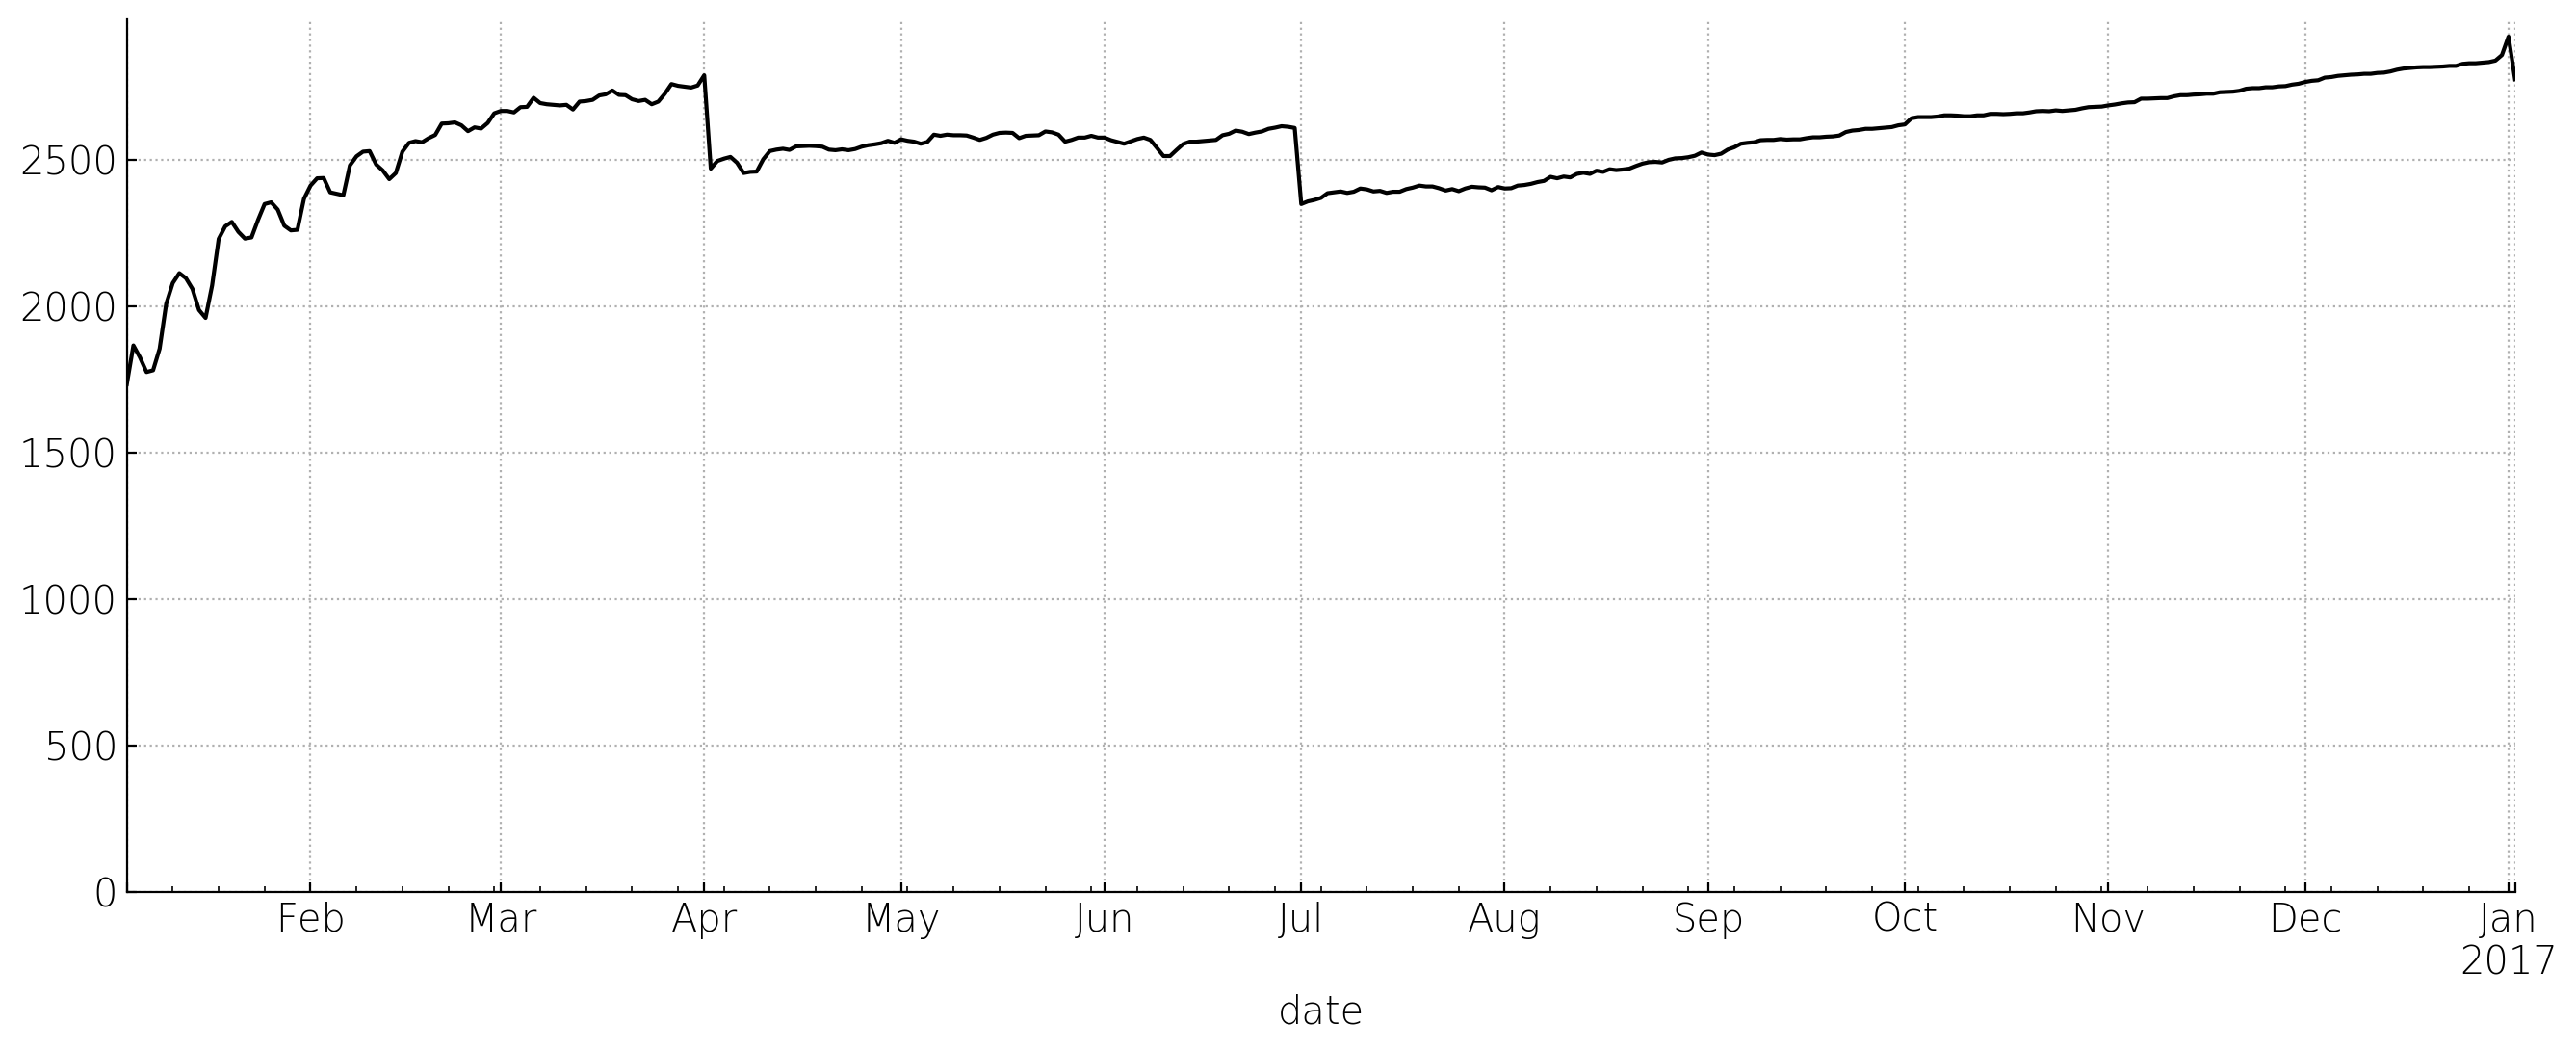

In [32]:
fig,ax = plt.subplots(figsize=(16,6), dpi=200)
calendar_clean[calendar_clean['available'] == 't'].groupby('date').size().plot(ax=ax, c='k')
ax.set_ylim(0,None);

The plot above shows the number of available listings for any given day of the year. Either there are some issues with the data or there are some very consistent trends. The sharp jumps at April and July signify that a lot of listings were either reserved or taken offline. 

## Q5: Consecutive rental days

In [33]:
calendar_pivot = calendar_clean.pivot(index='date', columns='listing_id', values='available')

consec_days = []
for col in calendar_pivot.columns:
    dat = calendar_pivot[col].reset_index()
    dat['grp'] = (dat[col] != dat[col].shift(1)).cumsum()
    dat = dat.groupby([col,'grp']).size().reset_index(name='consecutive_days')
    dat.columns = ['availability', 'group', 'consecutive_days']
    consec_days.append(dat)

res = reduce(lambda a,b : a.append(b), consec_days)

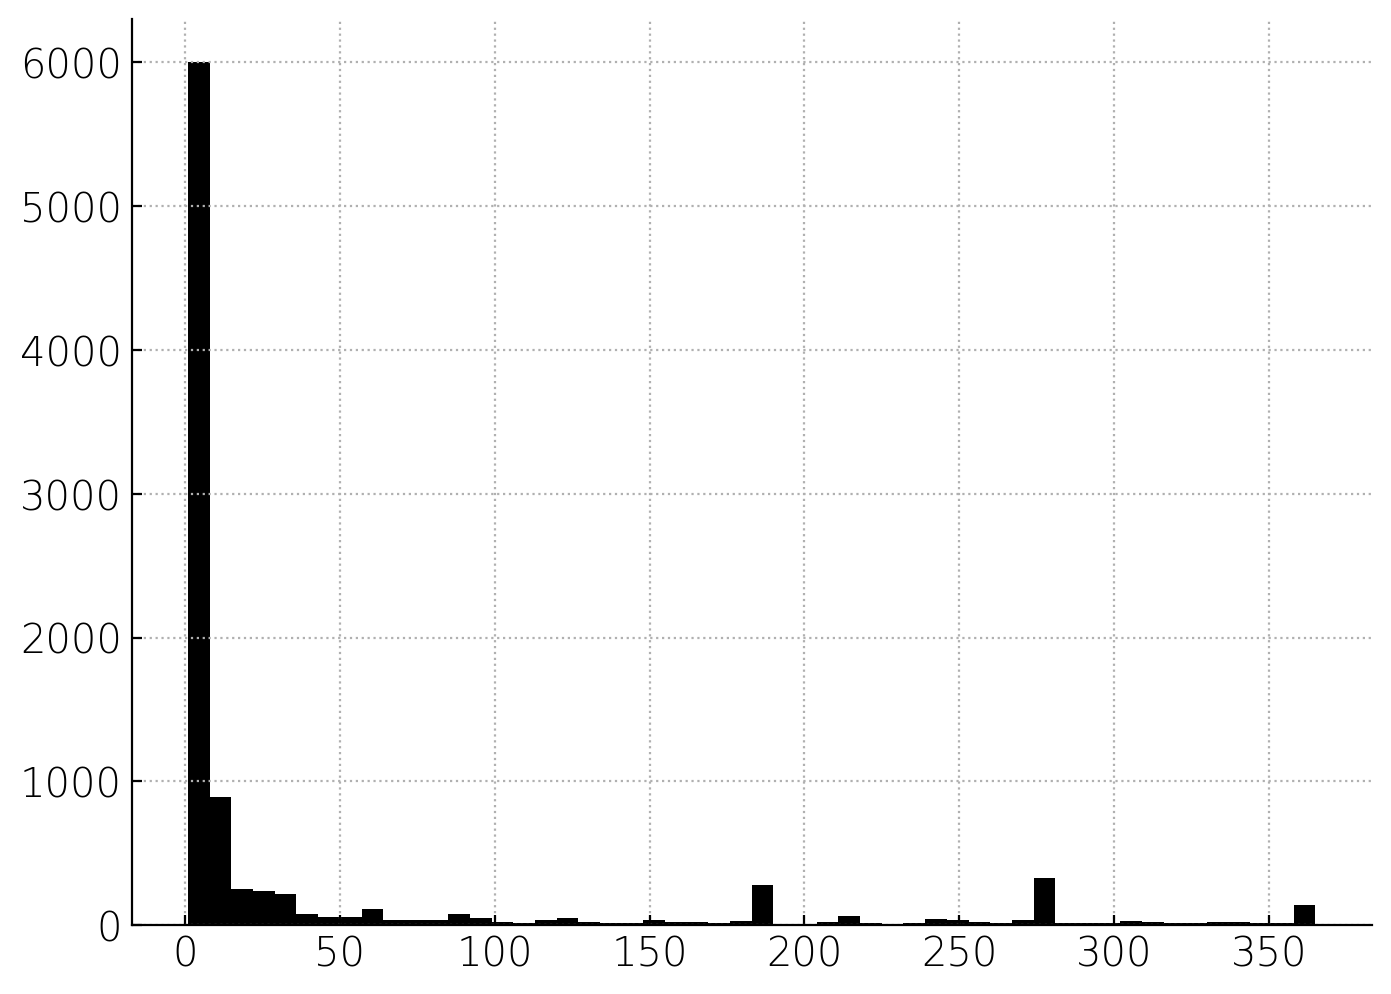

In [34]:
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
consecutive_rented_days = res[res['availability'] == 'f']['consecutive_days']
bins = ax.hist(consecutive_rented_days, bins=52, color='k')
ax.set_yscale('linear');

- Caveat, might not be distinct customers (neck to neck bookings)
- Might not show longer than a year bookings also, since we only look at data for a year (not so critical)


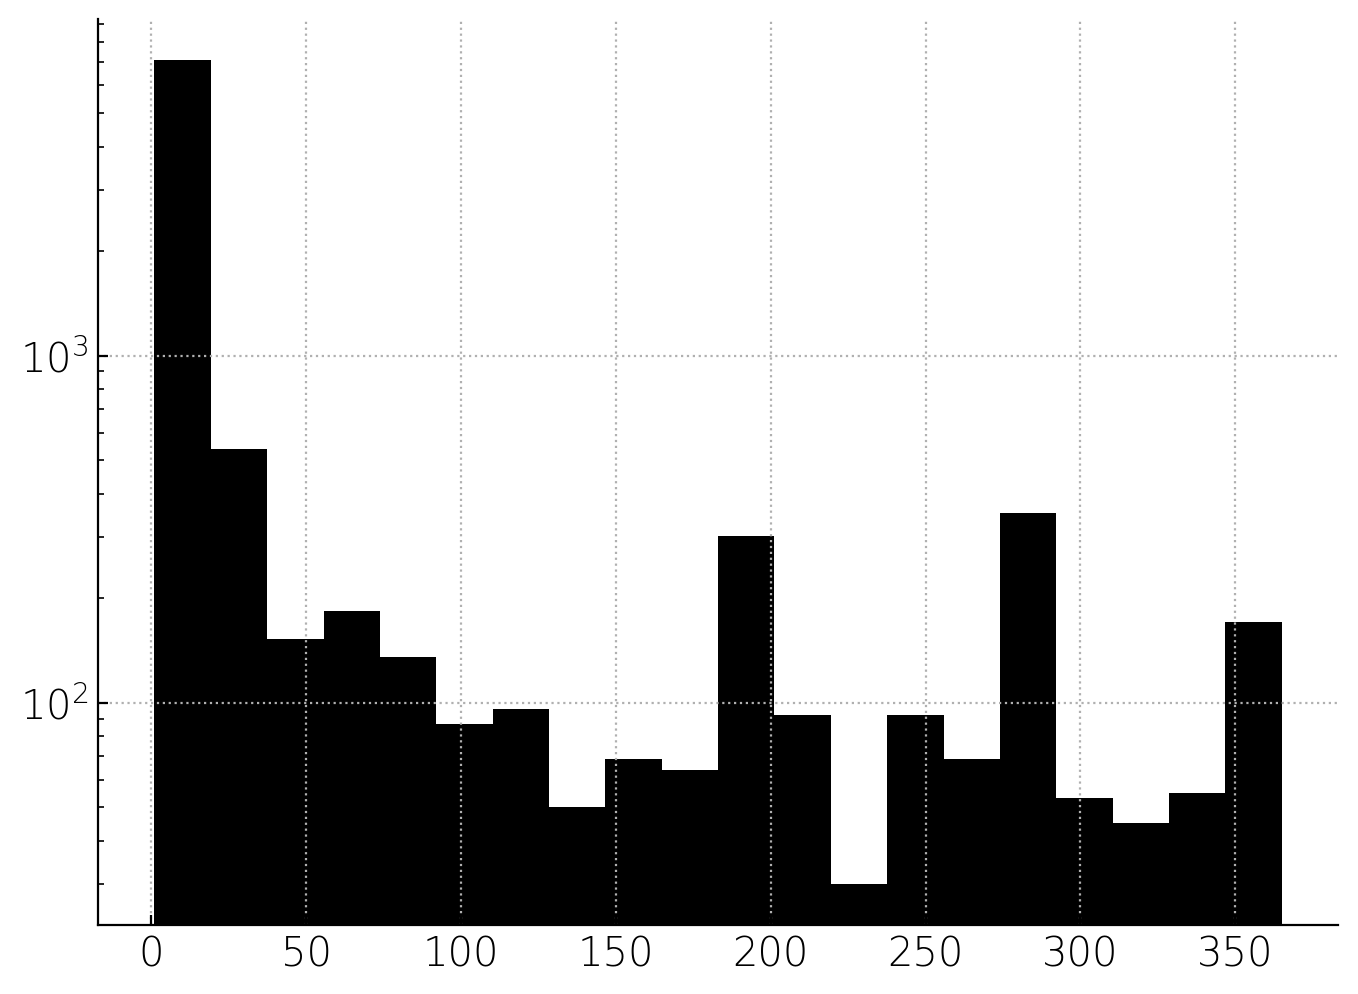

In [35]:
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
consecutive_rented_days = res[res['availability'] == 'f']['consecutive_days']
ax.hist(consecutive_rented_days, bins=20, color='k')
ax.set_yscale('log')

## Are there any property types that show a norm of amount of consecutive rented days

In [36]:
calendar_pivot = calendar_clean.pivot(index='date', columns='listing_id', values='available')

consec_days = []
for col in calendar_pivot.columns:
    dat = calendar_pivot[col].reset_index()
    dat['grp'] = (dat[col] != dat[col].shift(1)).cumsum()
    dat = dat.groupby([col,'grp']).size().reset_index(name='consecutive_days')
    dat.columns = ['availability', 'group', 'consecutive_days']
    dat['listing_id'] = col
    consec_days.append(dat)

res = reduce(lambda a,b : a.append(b), consec_days)

In [37]:
res.head()

,availability,group,consecutive_days,listing_id
0,f,1,56,3335
1,t,2,309,3335
0,t,1,365,4291
0,f,1,7,5682
1,f,3,3,5682


In [38]:
tmp = res[res['availability'] == 'f'].merge(listings_clean[['id','property_type']], left_on='listing_id', right_on='id')

In [39]:
tmp.pivot(columns='property_type', values='consecutive_days')

property_type,NaN,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt
0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.0,NaN,NaN,NaN,NaN,NaN,NaN
9715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
9716,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9717,NaN,365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
tmp_piv = tmp.pivot(columns='property_type', values='consecutive_days')

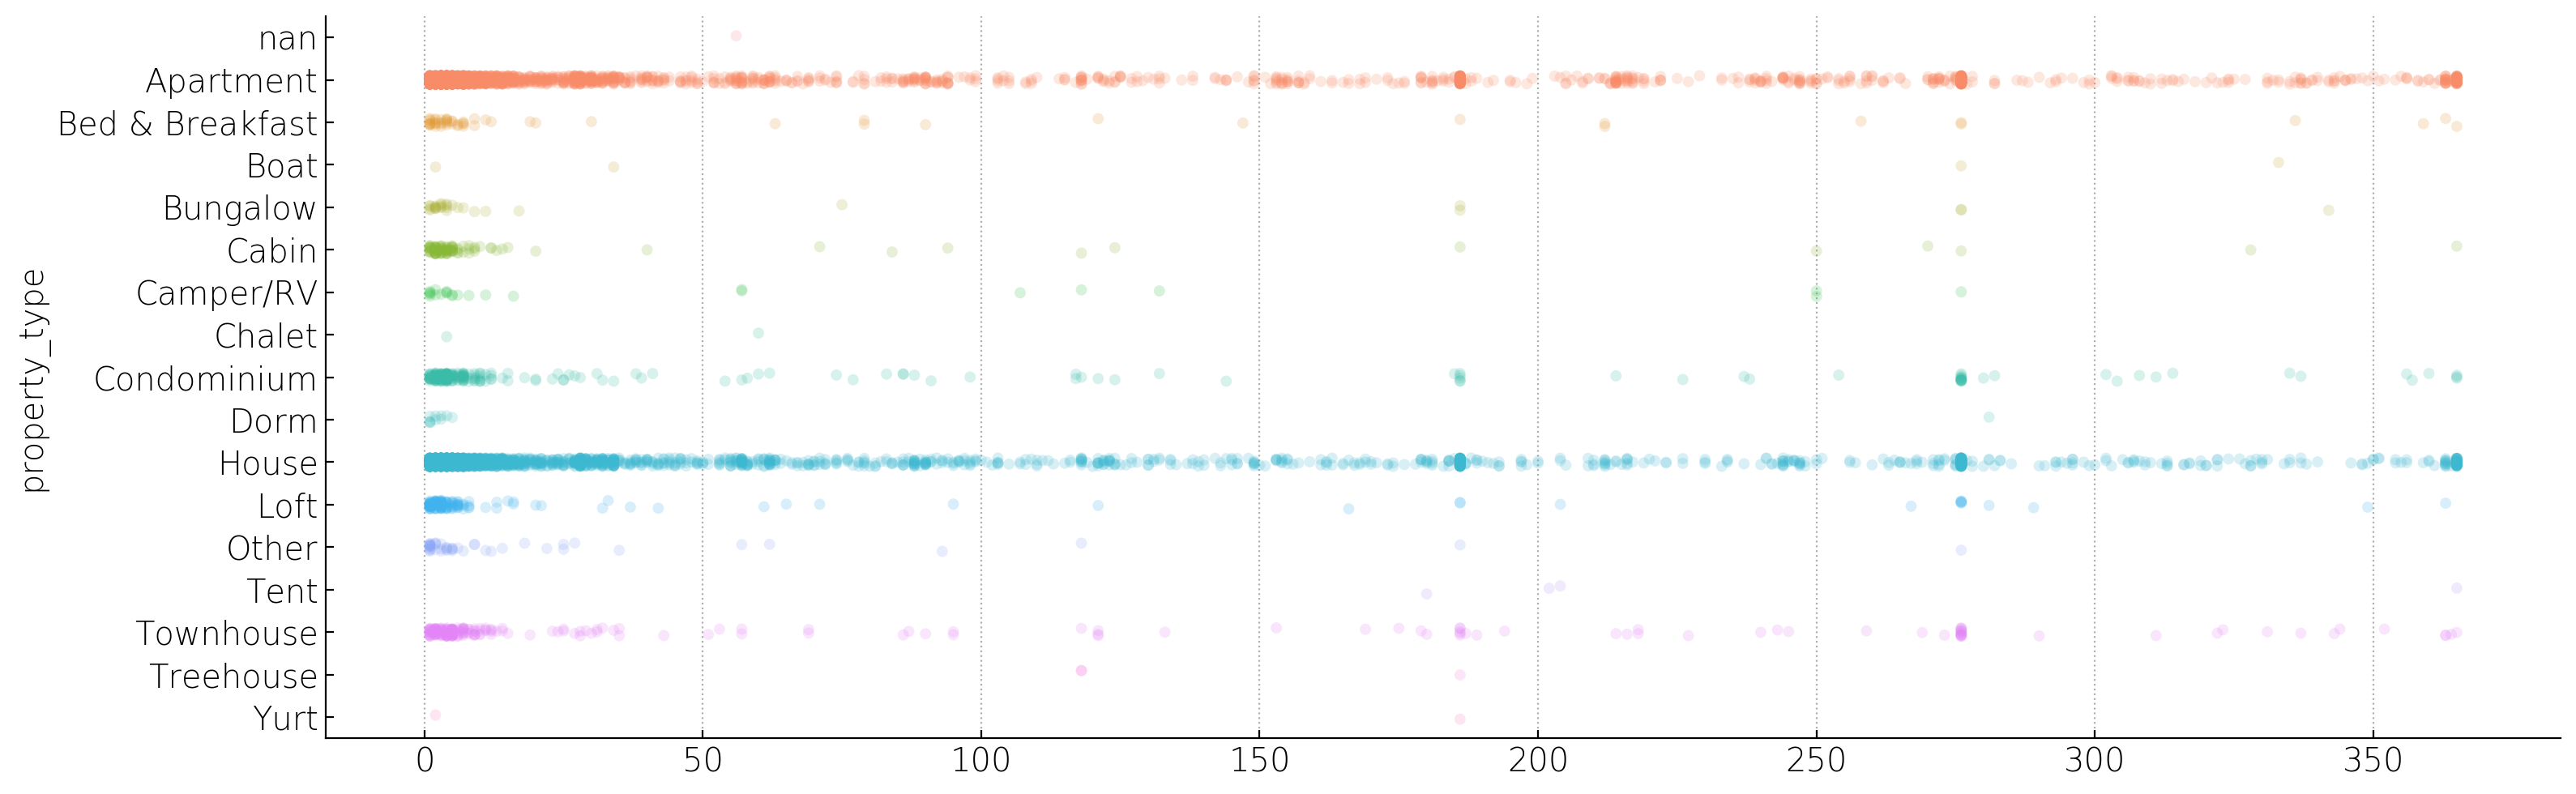

In [41]:
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.stripplot(data=tmp_piv, orient='h', ax=ax, alpha=.2)
fig.set_tight_layout(True);

# What features have inpact on price?

## Feature generation

In [42]:
# We want a response variable that always has labels, as opposed to the above analysis
calendar_clean = calendar_clean[calendar_clean['available'] == 't']
# Joining the listings and calendar dataset, and dropping price columns from listings in order not to collide with calendar price column
X = listings_clean.drop('price', axis=1).merge(calendar_clean, left_on='id', right_on='listing_id')

In [43]:
# Definition of selected columns and their types
continuous = [
    'host_response_rate',
    'host_acceptance_rate',
    'host_listings_count',
    'host_total_listings_count',
    'zipcode',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'guests_included',
    'extra_people',
    'minimum_nights',
    'maximum_nights',
    'square_feet',
    'cleaning_fee',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month'
]
dates = [
    'host_since',
    'first_review',
    'last_review'
]
categorical = [
    'host_response_time',
    'host_location',
    'host_is_superhost',
    'host_neighbourhood',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'city',
    'state',
    'market',
    'smart_location',
    'country_code',
    'country',
    'property_type',
    'room_type',
    'bed_type'
]
# Response variable that we would like to predict
response = [
    'cleaned_price'
]

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X[continuous+dates+categorical], X[response], test_size=.25)

In [46]:
X_train = pd.get_dummies(X_train, columns=categorical)
X_test = pd.get_dummies(X_test, columns=categorical)

In [47]:
X_train.to_pickle(DATA_FOLDER / 'X_train.pkl')
X_test.to_pickle(DATA_FOLDER / 'X_test.pkl')
y_train.to_pickle(DATA_FOLDER / 'y_train.pkl')
y_test.to_pickle(DATA_FOLDER / 'y_test.pkl')

## Modelling

In [ ]:
X_train.T

In [2]:
X_train = pd.read_pickle(DATA_FOLDER / 'X_train.pkl')
X_test = pd.read_pickle(DATA_FOLDER / 'X_test.pkl')
y_train = pd.read_pickle(DATA_FOLDER / 'y_train.pkl')
y_test = pd.read_pickle(DATA_FOLDER / 'y_test.pkl')

NameError: name 'pd' is not defined

In [1]:
X_train

NameError: name 'X_train' is not defined

In [7]:
import xgboost as xgb

In [8]:
X_train.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,zipcode,accommodates,bathrooms,bedrooms,beds,guests_included,...,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
590162,80.0,100.0,2.0,2.0,98125,2,1.0,1.0,1.0,1,...,0,0,0,1,0,0,0,0,0,1
221355,100.0,100.0,5.0,5.0,98122,2,3.0,1.0,1.0,2,...,0,0,0,1,0,0,0,0,0,1
205374,100.0,100.0,1.0,1.0,98122,3,1.0,1.0,1.0,1,...,0,0,1,0,0,0,0,0,0,1
68635,100.0,NaN,1.0,1.0,98105,2,1.0,1.0,1.0,1,...,0,0,1,0,0,0,0,0,0,1
716178,50.0,100.0,1.0,1.0,98102,3,1.0,1.0,1.0,1,...,0,0,1,0,0,0,0,0,0,1


In [9]:
xgtrain = xgb.DMatrix(X_train.values, y_train.values)

ValueError: could not convert string to float: '$51.00'

In [79]:
# specify parameters via map
param = {'max_depth':10, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, xgtrain, num_round)
# make prediction
preds = bst.predict(dtest)

TypeError: 'int' object is not iterable